In [1]:
suppressPackageStartupMessages({ 
    library(data.table) 
    library(dplyr) 
    library(ggplot2) 
    library(SingleCellExperiment)
    library(dplyr)
    library(celldex)
    library(SingleR)
    library(RColorBrewer)
    library(scater) 
    library(StabMap) 
    library(scran) 
    library(harmony) 
    library(patchwork)
    library(Seurat)
    library(plotly)
    library(pheatmap)
    library(batchelor)
    library(ggpubr)
    library(cowplot)
    library(viridis)
    library(patchwork)
    library(Cairo)
    library(grid)
    library(png)
})

## Data Locations

In [2]:
##### Load in Seurat Objects for post QC analyses #####

io = list()
io$main = "/rds/project/rds-SDzz0CATGms/users/ltgh2" # this is the main directory

# Set the working directory
setwd(io$main)

io$atlas = file.path(io$main, "projects/03_seqFISH_FINAL/code/extended_atlas_integration/processed_downsampled/downsample_10K_within_timpoint_all_stages.Rds")
io$seqFISH = file.path(io$main, "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_after_QC_filtering_within_and_across_dataset_integration_without_neighbour_features_E6_7_8.Rds") 

##### Load in StabMAP_Outputs #####
io$StabMAP_reweighted_MNNcorrected_original_counts_without_neigh = file.path(io$main, "projects/03_seqFISH_FINAL/code/stab_map_all_together_post_QC/output/StabMAP_allstages_postQC_reweighted_MNNcorrected_original_counts_without_neigh.Rds")
io$StabMAP_reweighted_MNNcorrected_integrated_counts_without_neigh = file.path(io$main, "projects/03_seqFISH_FINAL/code/stab_map_all_together_post_QC/output/StabMAP_allstages_postQC_reweighted_MNNcorrected_integrated_counts_without_neigh.Rds")

## Load in the seqFISH CellType Labels
io$seqFISH_labels = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_label_transfer/output/StabMAP_all_stages_post_QC_reweighted_MNNcorrected_original_counts_without_neigh_LABELS.Rds")

## Load in the seqFISH Imputed Gene Expression
io$seqFISH_imputed_logcounts_e6 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e6_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e7 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e7_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e8_1 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e8_embryo1_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e8_2 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e8_embryo2_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e8_3 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e8_embryo3_postQC_imputed_RNA.Rds")

## Load in the seqFISH UMAP coordinates
io$UMAP_coordinates = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/stab_map_umap_generation/processed/StabMAP_allstage_postQC_MNNoriginal_UMAP.rds")

## Load in the seqFISH object with all cells
io$seqFISH_preQC = file.path(io$main, "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_within_and_across_dataset_integration_without_neighbour_features_E6_7_8.Rds") 

##### Load in within timepoint integrated Seurat Objects for pre and post QC analyses #####
io$timepoint_pre_QC = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_within_dataset_integration_without_neighbour_features_E6_7_8.Rds")

io$timepoint_post_QC = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_after_QC_filtering_within_dataset_integration_without_neighbour_features_E6_7_8.Rds")

##### Load in within timepoint integrated Seurat Objects for pre and post QC analyses #####
io$post_QC_early_embryos_ONLY = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_after_QC_filtering_within_and_across_dataset_integration_without_neighbour_features_E6_7_ONLY.Rds")

##### Load in within timepoint integrated Seurat Objects for pre and post QC analyses #####
io$refined_annotations = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/GITHUB_SUBMISSION/outputs/FINAL_REFINED_ANNOTATIONS.Rds")

## Load in Seurat Objects and to the Seurat Object add the StabMAP UMAP, Transferred Cell Type Labels and Imputed Gene Expression Matrix

In [3]:
# Load in the seqFISH object_postQC
seqFISH = readRDS(io$seqFISH)

# Load in celltype, stage and anatomy labels
seqFISH_labels = readRDS(io$seqFISH_labels)

# Update the colnames in the seqFISH meta.data
seqFISH_labels_updated <- seqFISH_labels
colnames(seqFISH_labels_updated) <- c("nearest_cell_label_transfer", "celltype_extended_atlas", "stage", "anatomy", "somite_count")


seqFISH <- AddMetaData(seqFISH, metadata = seqFISH_labels_updated)

# Load in the imputed gene expression 
seqFISH_imputed_logcounts_e6 = readRDS(io$seqFISH_imputed_logcounts_e6)
seqFISH_imputed_logcounts_e7 = readRDS(io$seqFISH_imputed_logcounts_e7)
seqFISH_imputed_logcounts_e8_1 = readRDS(io$seqFISH_imputed_logcounts_e8_1)
seqFISH_imputed_logcounts_e8_2 = readRDS(io$seqFISH_imputed_logcounts_e8_2)
seqFISH_imputed_logcounts_e8_3 = readRDS(io$seqFISH_imputed_logcounts_e8_3)

# Create a combined matrix of gene expression across all time points
imputed_expression <- cbind(seqFISH_imputed_logcounts_e6$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e7$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e8_1$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e8_2$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e8_3$scRNA.RNA)

# Creat a new assay object to store imputed data
imp <- CreateAssayObject(data = imputed_expression)

# add this assay to the previously created Seurat object
seqFISH[["imputed"]] <- imp

seqFISH_postQC <- seqFISH

# Load in the seqFISH object_preQC
seqFISH_preQC = readRDS(io$seqFISH_preQC)

timepoint_pre_QC = readRDS(io$timepoint_pre_QC)
timepoint_post_QC = readRDS(io$timepoint_post_QC)

post_QC_early_embryos_ONLY = readRDS(io$post_QC_early_embryos_ONLY)

refined_annotations <- readRDS(io$refined_annotations)

## Update the Embryo Labels in the Seurat Objects

In [4]:
update_embryo_names <- function(seurat_obj) {
    # Define the mapping for renaming embryos
    embryo_mapping <- c("embryo1" = "embryo_5",
                        "embryo2" = "embryo_6",
                        "embryo3" = "embryo_7",
                        "embryo6" = "embryo_1",
                        "embryo7" = "embryo_2",
                        "embryo4" = "embryo_3",
                        "embryo5" = "embryo_4")

    embryo_sf_mapping <- c("embryo1" = "5",
                           "embryo2" = "6",
                           "embryo3" = "7",
                           "embryo6" = "1",
                           "embryo7" = "2",
                           "embryo4" = "3",
                           "embryo5" = "4")

    # Update embryo names
    seurat_obj@meta.data$embryo_name_updated <- embryo_mapping[seurat_obj@meta.data$embryo]
    seurat_obj@meta.data$embryo_name_updated_sf <- embryo_sf_mapping[seurat_obj@meta.data$embryo]
    
    return(seurat_obj)
}

# Example usage:
seqFISH_preQC <- update_embryo_names(seqFISH_preQC)
seqFISH_postQC <- update_embryo_names(seqFISH_postQC)

timepoint_pre_QC$E6.5 <- update_embryo_names(timepoint_pre_QC$E6.5)
timepoint_pre_QC$E7.5 <- update_embryo_names(timepoint_pre_QC$E7.5)
timepoint_pre_QC$E8.5 <- update_embryo_names(timepoint_pre_QC$E8.5)

timepoint_post_QC$E6.5 <- update_embryo_names(timepoint_post_QC$E6.5)
timepoint_post_QC$E7.5 <- update_embryo_names(timepoint_post_QC$E7.5)
timepoint_post_QC$E8.5 <- update_embryo_names(timepoint_post_QC$E8.5)

post_QC_early_embryos_ONLY <- update_embryo_names(post_QC_early_embryos_ONLY)

## Quality Control based on Clustering

In [5]:
# lets add a new metadata column that indicates which cells passed QC
seqFISH_postQC@meta.data$passed_QC <- "TRUE"
cells_that_passed_QC_metadata <- subset(seqFISH_postQC@meta.data, select = passed_QC)

timepoint_pre_QC$E6.5 <- AddMetaData(timepoint_pre_QC$E6.5, metadata = cells_that_passed_QC_metadata)
timepoint_pre_QC$E7.5 <- AddMetaData(timepoint_pre_QC$E7.5, metadata = cells_that_passed_QC_metadata)
timepoint_pre_QC$E8.5 <- AddMetaData(timepoint_pre_QC$E8.5, metadata = cells_that_passed_QC_metadata)

In [6]:
# Set passed_QC to FALSE where it is NA
timepoint_pre_QC$E6.5@meta.data$passed_QC <- ifelse(is.na(timepoint_pre_QC$E6.5@meta.data$passed_QC), "FALSE", timepoint_pre_QC$E6.5@meta.data$passed_QC)

# Set passed_QC to FALSE where it is NA
timepoint_pre_QC$E7.5@meta.data$passed_QC <- ifelse(is.na(timepoint_pre_QC$E7.5@meta.data$passed_QC), "FALSE", timepoint_pre_QC$E7.5@meta.data$passed_QC)

# Set passed_QC to FALSE where it is NA
timepoint_pre_QC$E8.5@meta.data$passed_QC <- ifelse(is.na(timepoint_pre_QC$E8.5@meta.data$passed_QC), "FALSE", timepoint_pre_QC$E8.5@meta.data$passed_QC)

## Explore spatial location of the clusters

In [7]:
post_QC_early_embryos_ONLY[["spatial"]] <- seqFISH_postQC[,seqFISH_postQC@meta.data$Estage %in% c("E6.5", "E7.5")][["spatial"]]

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from shila_umap_ to shilaumap_”


In [8]:
seqFISH_preQC_E6_E7_ONLY <- seqFISH_preQC[,seqFISH_preQC@meta.data$Estage %in% c("E6.5", "E7.5")]

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from shila_umap_ to shilaumap_”


In [9]:
#get seurat clusters for the post_QC integrated object for E6_E7
post_QC_early_embryos_ONLY_seurat_clusters <- subset(post_QC_early_embryos_ONLY@meta.data, select = across_timepoint_integration_snn_res.1.2)
colnames(post_QC_early_embryos_ONLY_seurat_clusters) <- "post_QC_clusters"

head(post_QC_early_embryos_ONLY_seurat_clusters)

,post_QC_clusters
,<fct>
embryo6_Pos0_cell2,2
embryo6_Pos0_cell3,6
embryo6_Pos0_cell4,6
embryo6_Pos0_cell7,6
embryo6_Pos0_cell8,13
embryo6_Pos0_cell10,6


In [10]:
seqFISH_preQC_E6_E7_ONLY <- AddMetaData(seqFISH_preQC_E6_E7_ONLY, metadata = post_QC_early_embryos_ONLY_seurat_clusters)

In [11]:
# Convert factor column to character
seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters <- as.character(seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters)

# Check if the column contains NA values
na_indices <- is.na(seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters)

# Assign "failed_qc" only to NA values
seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters[na_indices] <- "failed_qc"

In [12]:
table(seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters)


        0         1        10        11        12        13        14        15 
     1183      1084       398       307       289       281        78        72 
        2         3         4         5         6         7         8         9 
      921       867       859       746       728       525       454       445 
failed_qc 
     5557 

In [13]:
# Ensure uniqueness and add new levels
seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters <- factor(seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters)

In [14]:
head(seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters)

[1] 2         6         6         failed_qc failed_qc 6        
Levels: 0 1 10 11 12 13 14 15 2 3 4 5 6 7 8 9 failed_qc

In [15]:
# Reorder the levels of the factor variable
seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters <- factor(
  seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters,
  levels = c("failed_qc", sort(as.numeric(levels(seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters))))
)

Warning message in sort(as.numeric(levels(seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters))):
“NAs introduced by coercion”


In [16]:
table(seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_cluster, seqFISH_preQC_E6_E7_ONLY@meta.data$embryo)

           
            embryo4 embryo5 embryo6 embryo7
  failed_qc    1631     978    1428    1520
  0             804     231     107      41
  1             798     182      32      72
  2              10       2     327     582
  3             238     210     245     174
  4             268     221     190     180
  5             606      90      40      10
  6              11       9     417     291
  7               1       0     286     238
  8               6       4     189     255
  9               0       3      47     395
  10              2       0     199     197
  11              1       0     128     178
  12            127     116      16      30
  13              3       0     136     142
  14             39      37       2       0
  15              0       0      22      50

In [17]:
str(seqFISH_preQC_E6_E7_ONLY@meta.data$post_QC_clusters)

 Factor w/ 17 levels "failed_qc","0",..: 4 8 8 1 1 8 15 1 8 4 ...


## Add names to the seurat clusters and also include a nice colour panel

In [18]:
post_QC_early_embryos_ONLY <- AddMetaData(post_QC_early_embryos_ONLY, metadata = refined_annotations)

## Re sub-cluster the APS 

In [19]:
colnames(post_QC_early_embryos_ONLY@meta.data)

[1] "orig.ident"                                          
 [2] "nCount_originalexp"                                  
 [3] "nFeature_originalexp"                                
 [4] "dim1"                                                
 [5] "dim2"                                                
 [6] "dim3"                                                
 [7] "sample_id"                                           
 [8] "embryo"                                              
 [9] "pos"                                                 
[10] "fov"                                                 
[11] "Experiment"                                          
[12] "DataStage"                                           
[13] "Estage"                                              
[14] "pixel_width"                                         
[15] "area_um2"                                            
[16] "sum"                                                 
[17] "detected"                                            
[18] "total"                                               
[19] "quality_keep"                                        
[20] "sizeFactor"                                          
[21] "cell_ID"                                             
[22] "within_timepoint_integration_snn_res.1"              
[23] "seurat_clusters"                                     
[24] "across_timepoint_integration_snn_res.1.2"            
[25] "embryo_name_updated"                                 
[26] "embryo_name_updated_sf"                              
[27] "nCount_RNA"                                          
[28] "nFeature_RNA"                                        
[29] "seqFISH_celltype"                                    
[30] "extended_atlas_celltype"                             
[31] "AP"                                                  
[32] "DV"                                                  
[33] "dataset"                                             
[34] "cluster"                                             
[35] "subcluster"                                          
[36] "cluster_subcluster"                                  
[37] "stage"                                               
[38] "anatomy"                                             
[39] "UMAP_1"                                              
[40] "UMAP_2"                                              
[41] "celltype_PijuanSala2019"                             
[42] "majority_seqFISH_celltype"                           
[43] "majority_seqFISH_celltype_proportion"                
[44] "majority_extended_atlas_celltype"                    
[45] "majority_extended_atlas_celltype_proportion"         
[46] "majority_celltype_PijuanSala2019_celltype"           
[47] "majority_celltype_PijuanSala2019_celltype_proportion"
[48] "stage_transfer"                                      
[49] "poor_stage_alignment"                                
[50] "proportion_seqFISH_cells_per_subcluster"             
[51] "joint_clusters_pass_QC"                              
[52] "stage_alignment_pass_QC"                             
[53] "passed_QC"                                           
[54] "refined_annotation"

In [20]:
post_QC_early_embryos_ONLY_non_APS <- post_QC_early_embryos_ONLY[,
                                 !post_QC_early_embryos_ONLY@meta.data$seqFISH_celltype %in% c("anterior primitive streak" 
                                                            #"primitive streak"
                                                                                             )]

In [21]:
other_celltypes <- subset(post_QC_early_embryos_ONLY_non_APS@meta.data, select = seqFISH_celltype)

In [22]:
colnames(other_celltypes) <- "seqFISH_celltype_updated"

In [23]:
head(other_celltypes)

,seqFISH_celltype_updated
,<fct>
embryo6_Pos0_cell2,primitive streak
embryo6_Pos0_cell3,epiblast
embryo6_Pos0_cell4,epiblast
embryo6_Pos0_cell7,epiblast
embryo6_Pos0_cell10,epiblast
embryo6_Pos0_cell11,primitive streak


In [24]:
# keep only APS cells for re-clustering
post_QC_early_embryos_ONLY_APS <- post_QC_early_embryos_ONLY[,
                                 post_QC_early_embryos_ONLY@meta.data$seqFISH_celltype %in% c("anterior primitive streak")]

# recluster the APS
post_QC_early_embryos_ONLY_APS <- FindNeighbors(post_QC_early_embryos_ONLY_APS, reduction = "pca", dims = 1:30)
post_QC_early_embryos_ONLY_APS <-   FindClusters(post_QC_early_embryos_ONLY_APS, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 281
Number of edges: 17021

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4018
Number of communities: 3
Elapsed time: 0 seconds


In [25]:
APS_subcluster <- subset(post_QC_early_embryos_ONLY_APS@meta.data, select = seurat_clusters)

In [26]:
APS_subcluster$seurat_clusters <- paste0("anterior primitive streak", "_", APS_subcluster$seurat_clusters)

In [27]:
colnames(APS_subcluster) <- "seqFISH_celltype_updated"

In [28]:
seqFISH_celltype_updated <- rbind(APS_subcluster, other_celltypes)

In [29]:
post_QC_early_embryos_ONLY <- AddMetaData(post_QC_early_embryos_ONLY, metadata = seqFISH_celltype_updated)

In [30]:
table(post_QC_early_embryos_ONLY@meta.data$seqFISH_celltype_updated)


               ExE endoderm                ExE mesoderm 
                        859                        1084 
anterior primitive streak_0 anterior primitive streak_1 
                        105                          92 
anterior primitive streak_2             caudal epiblast 
                         84                         746 
     distal ExE ectoderm #1      distal ExE ectoderm #2 
                        454                         525 
                   epiblast       haematoendothelial #1 
                        728                         289 
      haematoendothelial #2            mesodermal wings 
                         78                          72 
           primitive streak    proximal ExE ectoderm #1 
                        921                         867 
   proximal ExE ectoderm #2            rostral epiblast 
                        445                        1183 
       visceral endoderm #1        visceral endoderm #2 
                        398   

In [31]:
# rename the APS subclusters

#anterior primitive streak 2, should be renamed anterior definitive endoderm 
#anterior primitive streak 1, should be renamed anterior mesendoderm
#anterior primtive streak 0, should be renamed unknown 

post_QC_early_embryos_ONLY@meta.data$seqFISH_celltype_updated <- recode(post_QC_early_embryos_ONLY@meta.data$seqFISH_celltype_updated, 
                                                                       "anterior primitive streak_2" = "definitive endoderm",
                                                                       "anterior primitive streak_1" = "anterior mesendoderm",
                                                                       "anterior primitive streak_0" = "low quality mixed")

In [32]:
post_QC_early_embryos_ONLY@meta.data$seqFISH_celltype <- post_QC_early_embryos_ONLY@meta.data$seqFISH_celltype_updated

## Renaming and updating the colours

In [33]:
seqFISH_refined_annotation_colors <- c(
    # Epiblast and primitive streak populations
    "Epiblast" = "#635547",
    "Primitive Streak" = "#DABE99",
    "Rostral Ectoderm" = "#A48F73",
    "Caudal Epiblast" = "#9e6762",
    
    # Endodermal populations
    "Definitive Endoderm" = "#FFA500",  # Orange (Standard)
    "ExE Endoderm" = "#7F6874",
    "Visceral Endoderm #1" = "#F6BFCB",
    "Visceral Endoderm #2" = "#E89BAF",  # Slightly darker pinkish shade
    
    # Mesodermal populations
    "Axial Mesendoderm" = "#228B22",  # Green (Forest Green)
    "Mesodermal Wings" = "#3F84AA",
    "ExE Mesoderm" = "#956D91",  
    
    # Haematoendothelial populations
    "Haematoendothelial Progenitors #1" = "#FBBE92",  # Light Peach
    "Haematoendothelial Progenitors #2" = "#E69C72",  # Darker Peach/Salmon
    
    # Extraembryonic ectoderm
    "ExE Ectoderm Proximal #1" = "#696969",  # Dark Gray
    "ExE Ectoderm Proximal #2" = "#808080",  # Medium Gray
    "ExE Ectoderm Distal #1" = "#A0A0A0",  # Light Gray
    "ExE Ectoderm Distal #2" = "#C0C0C0",  # Even Lighter Gray
    
    # Low-quality/mixed classification
    "LQ" = "#B0B0B0",  # Neutral Light Gray for low-quality mixed cells
    "low quality" = "#B0B0B0"  # Neutral Light Gray for low-quality mixed cells
)

In [34]:
post_QC_early_embryos_ONLY@meta.data$seqFISH_celltype_updated_2 <- recode(
    post_QC_early_embryos_ONLY@meta.data$seqFISH_celltype_updated, 
    
    # Epiblast and primitive streak populations
    "primitive streak" = "Primitive Streak",
    "epiblast" = "Epiblast",
    "rostral epiblast" = "Rostral Ectoderm",
    "caudal epiblast" = "Caudal Epiblast",
    
    # Endoderm populations
    "definitive endoderm" = "Definitive Endoderm",
    "ExE endoderm" = "ExE Endoderm",
    "visceral endoderm #1" = "Visceral Endoderm #1",
    "visceral endoderm #2" = "Visceral Endoderm #2",
    
    # Mesodermal populations
    "anterior mesendoderm" = "Axial Mesendoderm",
    "mesodermal wings" = "Mesodermal Wings",
    "ExE mesoderm" = "ExE Mesoderm",
    
    # Haematoendothelial populations
    "haematoendothelial #1" = "Haematoendothelial Progenitors #1",
    "haematoendothelial #2" = "Haematoendothelial Progenitors #2",
    
    # Extraembryonic ectoderm
    "proximal ExE ectoderm #1" = "ExE Ectoderm Proximal #1",
    "proximal ExE ectoderm #2" = "ExE Ectoderm Proximal #2",
    "distal ExE ectoderm #1" = "ExE Ectoderm Distal #1",
    "distal ExE ectoderm #2" = "ExE Ectoderm Distal #2",
    
    # Low quality category
    "low quality mixed" = "LQ"
)

In [35]:
# Define the desired order: Endoderm (last), then Ectoderm, then Mesoderm
celltype_order <- c(
        # Ectoderm
    "Epiblast", "Rostral Ectoderm", "Caudal Epiblast", 
    
    # Mesoderm
    "Primitive Streak", "Mesodermal Wings", "Axial Mesendoderm",
    "Haematoendothelial Progenitors #1", "Haematoendothelial Progenitors #2", "ExE Mesoderm",
    

    # Endoderm (Last)
    "Definitive Endoderm", "ExE Endoderm",
    "Visceral Endoderm #1", "Visceral Endoderm #2",
    
    "ExE Ectoderm Proximal #1", "ExE Ectoderm Proximal #2",
    "ExE Ectoderm Distal #1", "ExE Ectoderm Distal #2", 
    "LQ"
)

# Convert column to factor with the defined order
post_QC_early_embryos_ONLY@meta.data$seqFISH_celltype_updated_2 <- 
    factor(post_QC_early_embryos_ONLY@meta.data$seqFISH_celltype_updated_2, levels = celltype_order)

## UMAP FIGURE E6_E7 POST_QC

In [36]:
post_QC_early_embryos_ONLY

An object of class Seurat 
1053 features across 9237 samples within 3 assays 
Active assay: across_timepoint_integration (351 features, 351 variable features)
 2 other assays present: originalexp, within_timepoint_integration
 3 dimensional reductions calculated: pca, umap, spatial

In [37]:
# Step 1: Extract UMAP coordinates
umap_coords <- as.matrix(post_QC_early_embryos_ONLY@meta.data[, c("UMAP_1", "UMAP_2")])

# Step 2: Add UMAP coordinates as a new reduction (e.g., named "custom_umap")
post_QC_early_embryos_ONLY[["custom_umap"]] <- CreateDimReducObject(
  embeddings = umap_coords,
  key = "customUMAP_",
  assay = DefaultAssay(post_QC_early_embryos_ONLY)
)

## Spatial FIGURE WITH CLUSTER E6_E7 ONLY

In [38]:
seqFISH_preQC_E6_E7_ONLY <- AddMetaData(seqFISH_preQC_E6_E7_ONLY, metadata = refined_annotations)

In [39]:
updated_seqFISH_celltype_labels <- subset(post_QC_early_embryos_ONLY@meta.data, select = seqFISH_celltype_updated_2)

In [40]:
seqFISH_preQC_E6_E7_ONLY <- AddMetaData(seqFISH_preQC_E6_E7_ONLY, metadata = updated_seqFISH_celltype_labels)

In [41]:
# Assuming seqFISH_preQC_E6_E7_ONLY is your Seurat object

seqFISH_preQC_E6_E7_ONLY@meta.data$seqFISH_celltype_updated_2 <- as.character(seqFISH_preQC_E6_E7_ONLY@meta.data$seqFISH_celltype_updated_2)

# Replace NA values in post_QC_clusters with "low quality"
seqFISH_preQC_E6_E7_ONLY@meta.data$seqFISH_celltype_updated_2[is.na(seqFISH_preQC_E6_E7_ONLY@meta.data$seqFISH_celltype_updated_2)] <- "low quality"

In [42]:
table(seqFISH_preQC_E6_E7_ONLY@meta.data$seqFISH_celltype_updated_2)


                Axial Mesendoderm                   Caudal Epiblast 
                               92                               746 
              Definitive Endoderm                          Epiblast 
                               84                               728 
           ExE Ectoderm Distal #1            ExE Ectoderm Distal #2 
                              454                               525 
         ExE Ectoderm Proximal #1          ExE Ectoderm Proximal #2 
                              867                               445 
                     ExE Endoderm                      ExE Mesoderm 
                              859                              1084 
Haematoendothelial Progenitors #1 Haematoendothelial Progenitors #2 
                              289                                78 
                               LQ                  Mesodermal Wings 
                              105                                72 
                 Primitive Streak

In [43]:
# Define the desired order: Endoderm (last), then Ectoderm, then Mesoderm
celltype_order <- c(
       "LQ", "low quality",
        # Ectoderm
    "Epiblast", "Rostral Ectoderm", "Caudal Epiblast", 
    
    # Mesoderm
    "Primitive Streak", "Mesodermal Wings", "Axial Mesendoderm",
    "Haematoendothelial Progenitors #1", "Haematoendothelial Progenitors #2", "ExE Mesoderm",
    

    # Endoderm (Last)
    "Definitive Endoderm", "ExE Endoderm",
    "Visceral Endoderm #1", "Visceral Endoderm #2",
    
    "ExE Ectoderm Proximal #1", "ExE Ectoderm Proximal #2",
    "ExE Ectoderm Distal #1", "ExE Ectoderm Distal #2"
 
)

# Convert column to factor with the defined order
seqFISH_preQC_E6_E7_ONLY@meta.data$seqFISH_celltype_updated_2 <- 
    factor(seqFISH_preQC_E6_E7_ONLY@meta.data$seqFISH_celltype_updated_2, levels = celltype_order)

## Regenerate the optical sections

In [44]:
# Assuming your data is in a data.frame-like object named meta.data
meta.data <- seqFISH_preQC_E6_E7_ONLY@meta.data

# Apply binning on a per-embryo basis
meta.data <- meta.data %>%
  group_by(embryo) %>%
  mutate(dim3_binarized = cut(
    dim3,
    breaks = 5,         # Number of bins
    labels = FALSE      # Assign numeric bin labels
  )) %>%
  ungroup()

# Convert dim3_binarized to numeric if needed
seqFISH_preQC_E6_E7_ONLY@meta.data$dim3_binarized<- as.numeric(meta.data$dim3_binarized)

## Save the Seurat Object

In [45]:
seqFISH_preQC_E6_E7_ONLY_META <- subset(seqFISH_preQC_E6_E7_ONLY@meta.data, select = c(seqFISH_celltype, seqFISH_celltype_updated_2, dim3_binarized, AP, DV, dim1, dim2, dim3, UMAP_1, UMAP_2, embryo_name_updated))

In [46]:
# Subset the metadata
seqFISH_preQC_E6_E7_ONLY_META <- subset(seqFISH_preQC_E6_E7_ONLY@meta.data, 
                                        select = c(seqFISH_celltype, 
                                                   seqFISH_celltype_updated_2, 
                                                   dim3_binarized, 
                                                   AP, DV, 
                                                   dim1, dim2, dim3, 
                                                   UMAP_1, UMAP_2, 
                                                   embryo_name_updated))

# Update specific column names
colnames(seqFISH_preQC_E6_E7_ONLY_META)[colnames(seqFISH_preQC_E6_E7_ONLY_META) == "UMAP_1"] <- "STABMAP_UMAP_1"
colnames(seqFISH_preQC_E6_E7_ONLY_META)[colnames(seqFISH_preQC_E6_E7_ONLY_META) == "UMAP_2"] <- "STABMAP_UMAP_2"
colnames(seqFISH_preQC_E6_E7_ONLY_META)[colnames(seqFISH_preQC_E6_E7_ONLY_META) == "embryo_name_updated"] <- "embryo"

# Print updated column names to verify
print(colnames(seqFISH_preQC_E6_E7_ONLY_META))

 [1] "seqFISH_celltype"           "seqFISH_celltype_updated_2"
 [3] "dim3_binarized"             "AP"                        
 [5] "DV"                         "dim1"                      
 [7] "dim2"                       "dim3"                      
 [9] "STABMAP_UMAP_1"             "STABMAP_UMAP_2"            
[11] "embryo"                    


In [47]:
seqFISH_preQC_E6_E7_ONLY_META$seqFISH_celltype <- as.character(seqFISH_preQC_E6_E7_ONLY_META$seqFISH_celltype)

In [48]:
seqFISH_preQC_E6_E7_ONLY_META$seqFISH_celltype[is.na(seqFISH_preQC_E6_E7_ONLY_META$seqFISH_celltype)] <- "low quality"

In [49]:
table(seqFISH_preQC_E6_E7_ONLY_META$seqFISH_celltype, useNA = "ifany")


             ExE endoderm              ExE mesoderm anterior primitive streak 
                      859                      1084                       281 
          caudal epiblast    distal ExE ectoderm #1    distal ExE ectoderm #2 
                      746                       454                       525 
                 epiblast     haematoendothelial #1     haematoendothelial #2 
                      728                       289                        78 
              low quality          mesodermal wings          primitive streak 
                     5557                        72                       921 
 proximal ExE ectoderm #1  proximal ExE ectoderm #2          rostral epiblast 
                      867                       445                      1183 
     visceral endoderm #1      visceral endoderm #2 
                      398                       307 

In [50]:
# Define output directory
output_dir <- "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/Figure_1_seurats"
if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
}


file_path_umap <- file.path(output_dir, "seqFISH_preQC_metadata.rds")
saveRDS(seqFISH_preQC_E6_E7_ONLY_META, file = file_path_umap)

In [51]:
post_QC_early_embryos_ONLY

An object of class Seurat 
1053 features across 9237 samples within 3 assays 
Active assay: across_timepoint_integration (351 features, 351 variable features)
 2 other assays present: originalexp, within_timepoint_integration
 4 dimensional reductions calculated: pca, umap, spatial, custom_umap

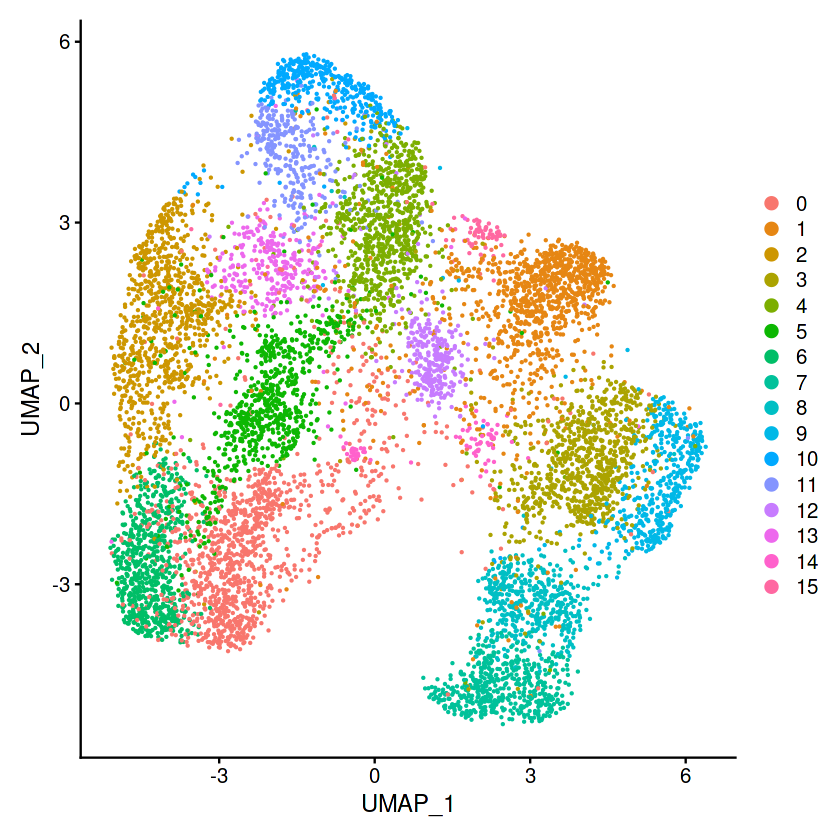

In [52]:
DimPlot(post_QC_early_embryos_ONLY, reduction = "umap")

In [53]:
colnames(post_QC_early_embryos_ONLY@meta.data)

[1] "orig.ident"                                          
 [2] "nCount_originalexp"                                  
 [3] "nFeature_originalexp"                                
 [4] "dim1"                                                
 [5] "dim2"                                                
 [6] "dim3"                                                
 [7] "sample_id"                                           
 [8] "embryo"                                              
 [9] "pos"                                                 
[10] "fov"                                                 
[11] "Experiment"                                          
[12] "DataStage"                                           
[13] "Estage"                                              
[14] "pixel_width"                                         
[15] "area_um2"                                            
[16] "sum"                                                 
[17] "detected"                                            
[18] "total"                                               
[19] "quality_keep"                                        
[20] "sizeFactor"                                          
[21] "cell_ID"                                             
[22] "within_timepoint_integration_snn_res.1"              
[23] "seurat_clusters"                                     
[24] "across_timepoint_integration_snn_res.1.2"            
[25] "embryo_name_updated"                                 
[26] "embryo_name_updated_sf"                              
[27] "nCount_RNA"                                          
[28] "nFeature_RNA"                                        
[29] "seqFISH_celltype"                                    
[30] "extended_atlas_celltype"                             
[31] "AP"                                                  
[32] "DV"                                                  
[33] "dataset"                                             
[34] "cluster"                                             
[35] "subcluster"                                          
[36] "cluster_subcluster"                                  
[37] "stage"                                               
[38] "anatomy"                                             
[39] "UMAP_1"                                              
[40] "UMAP_2"                                              
[41] "celltype_PijuanSala2019"                             
[42] "majority_seqFISH_celltype"                           
[43] "majority_seqFISH_celltype_proportion"                
[44] "majority_extended_atlas_celltype"                    
[45] "majority_extended_atlas_celltype_proportion"         
[46] "majority_celltype_PijuanSala2019_celltype"           
[47] "majority_celltype_PijuanSala2019_celltype_proportion"
[48] "stage_transfer"                                      
[49] "poor_stage_alignment"                                
[50] "proportion_seqFISH_cells_per_subcluster"             
[51] "joint_clusters_pass_QC"                              
[52] "stage_alignment_pass_QC"                             
[53] "passed_QC"                                           
[54] "refined_annotation"                                  
[55] "seqFISH_celltype_updated"                            
[56] "seqFISH_celltype_updated_2"

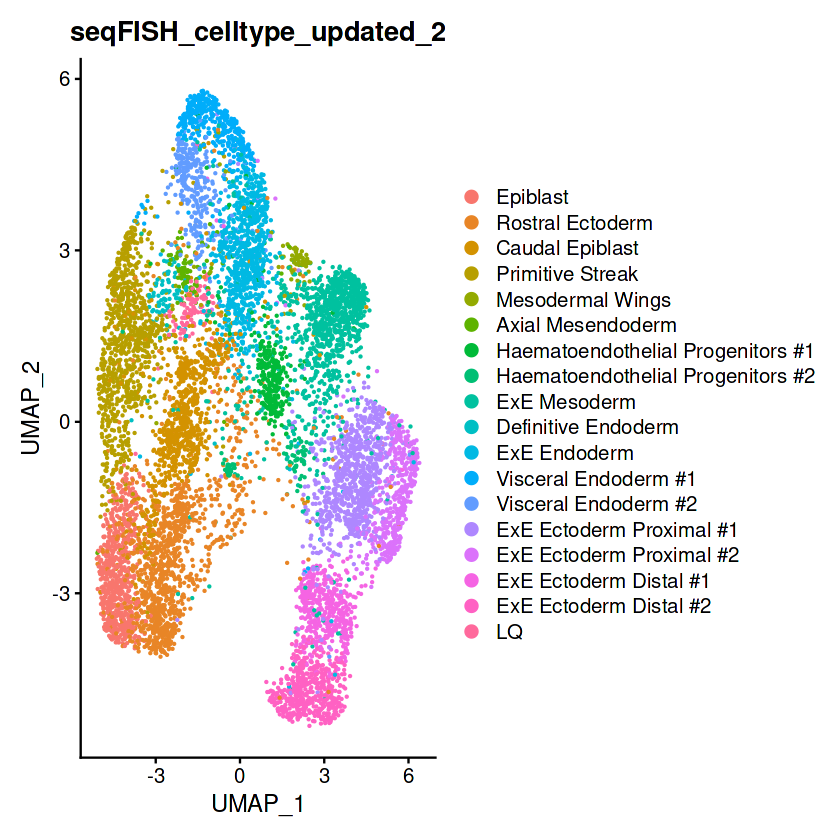

In [54]:
DimPlot(post_QC_early_embryos_ONLY, reduction = "umap", group.by = "seqFISH_celltype_updated_2")

In [55]:
# Define output directory
output_dir <- "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/Figure_1_seurats"
if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
}

# Extract and save UMAP coordinates
postQC_seqFISH_umap <- as.data.frame(post_QC_early_embryos_ONLY@reductions$umap@cell.embeddings)
colnames(postQC_seqFISH_umap) <- paste0("postQC_seqFISH_", colnames(postQC_seqFISH_umap))

file_path_umap <- file.path(output_dir, "postQC_seqFISH_umap.rds")
saveRDS(postQC_seqFISH_umap, file = file_path_umap)

# Extract and save UMAP reduction object
postQC_seqFISH_umap_dimreduced <- post_QC_early_embryos_ONLY@reductions$umap
file_path_umap_dimreduced <- file.path(output_dir, "postQC_seqFISH_umap_dimreduced.rds")
saveRDS(postQC_seqFISH_umap_dimreduced, file = file_path_umap_dimreduced)

# Extract and save PCA coordinates
postQC_seqFISH_pca <- as.data.frame(post_QC_early_embryos_ONLY@reductions$pca@cell.embeddings)
colnames(postQC_seqFISH_pca) <- paste0("postQC_seqFISH_", colnames(postQC_seqFISH_pca))

file_path_pca <- file.path(output_dir, "postQC_seqFISH_pca.rds")
saveRDS(postQC_seqFISH_pca, file = file_path_pca)

# Extract and save PCA reduction object
postQC_seqFISH_pca_dimreduced <- post_QC_early_embryos_ONLY@reductions$pca
file_path_pca_dimreduced <- file.path(output_dir, "postQC_seqFISH_pca_dimreduced.rds")
saveRDS(postQC_seqFISH_pca_dimreduced, file = file_path_pca_dimreduced)

# Print confirmation
print("All postQC UMAP and PCA files have been successfully saved.")

[1] "All postQC UMAP and PCA files have been successfully saved."


## Print out Package Versions

In [56]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] png_0.1-8                   Cairo_1.6-0                
 [3] viridis_0.6.2               viridisLite_0.4.1          
 [5] cowplot_1.1.1               ggpubr_0.4.0               
 [7] batchelor_1.12.3            pheatmap_1.0.12            
 [9] plotly_4.10.0               sp_1.5-0                   
[11] SeuratObject_4